Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Inference with Keras


<table class="tfo-notebook-buttons" align="left">
<td>
<a target="_blank" href="https://ai.google.dev/gemma/docs/paligemma/inference-with-keras"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
</td>
<td>
<a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/paligemma/inference-with-keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>
<td>
<a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/paligemma/inference-with-keras.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td>
</table>

When your AI model produces a conclusion or a prediction, it goes through a process called *inference*. This tutorial goes over how to use PaliGemma with Keras to set up a simple model that can infer information about supplied images and answer questions about them.

## What's in this notebook

This notebook uses PaliGemma with Keras and shows you how to:

* Install Keras and the required dependencies
* Download `PaliGemmaCausalLM`, a pre-trained PaliGemma variant for causal visual language modeling, and use it to create a model
* Test the model's ability to infer information about supplied images

## Before you begin

Before going through this notebook, you should be familiar with Python code, as well as how large language models (LLMs) are trained. You don't need to be familiar with Keras, but basic knowledge about Keras is helpful when reading through the example code.

## Setup

The following sections explain the preliminary steps for getting a notebook to use a PaliGemma model, including model access, getting an API key, and configuring the notebook runtime.

### Get access to PaliGemma

Before using PaliGemma for the first time, you must request access to the model through Kaggle by completing the following steps:

1. Log in to [Kaggle](https://www.kaggle.com), or create a new Kaggle account if you don't already have one.
1. Go to the [PaliGemma model card](https://www.kaggle.com/models/google/paligemma/) and click **Request Access**.
1. Complete the consent form and accept the terms and conditions.

### Configure your API key

To use PaliGemma, you must provide your Kaggle username and a Kaggle API key.

To generate a Kaggle API key, open your [**Settings** page in Kaggle](https://www.kaggle.com/settings) and click **Create New Token**. This triggers the download of a `kaggle.json` file containing your API credentials.

Then, in Colab, select **Secrets** (🔑) in the left pane and add your Kaggle username and Kaggle API key. Store your username under the name `KAGGLE_USERNAME` and your API key under the name `KAGGLE_KEY`.

### Select the runtime

To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the PaliGemma model. In this case, you can use a T4 GPU:

1. In the upper-right of the Colab window, click the **▾ (Additional connection options)** dropdown menu.
1. Select **Change runtime type**.
1. Under **Hardware accelerator**, select **T4 GPU**.

### Set environment variables

Set the environment variables for `KAGGLE_USERNAME`, `KAGGLE_KEY`, and `KERAS_BACKEND`.

In [2]:
import os
from google.colab import userdata

# Set up environmental variables
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KERAS_BACKEND"] = "jax"

### Install Keras

Run the below cell to install Keras.

In [3]:
!pip install -U -q keras-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 93.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatib

### Import dependencies and configure Keras

Install the dependencies needed for this notebook and configure Keras' backend. You'll also set Keras to use `bfloat16` so that the framework uses less memory.

In [4]:
import keras
import keras_nlp
import numpy as np
import PIL
import requests
import io
import matplotlib
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

keras.config.set_floatx("bfloat16")

## Create your model

Now that you've set everything up, you can download the pre-trained model and create some utility methods to help your model generate its responses.

### Download the model checkpoint

KerasNLP provides implementations of many popular [model architectures](https://keras.io/api/keras_nlp/models/). In this notebook, you'll create a model using `PaliGemmaCausalLM`, an end-to-end PaliGemma model for *causal visual language modeling*. A causal visual language model predicts the next token based on previous tokens.

Create the model using the `from_preset` method and print its summary. This process will take about a minute to complete.

In [5]:
paligemma = keras_nlp.models.PaliGemmaCausalLM.from_preset("pali_gemma_3b_mix_224")
paligemma.summary()

100%|██████████| 143/143 [00:00<00:00, 359kB/s]


100%|██████████| 861/861 [00:00<00:00, 1.89MB/s]


100%|██████████| 5.45G/5.45G [02:44<00:00, 35.5MB/s]


100%|██████████| 410/410 [00:00<00:00, 415kB/s]


100%|██████████| 4.07M/4.07M [00:00<00:00, 8.37MB/s]


Preprocessor: "pali_gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pali_gemma_tokenizer (PaliGemmaTokenizer)          │                                             257,152 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "pali_gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)           │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ response_mask (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pali_gemma_backbone           │ (None, None, 2048)        │   2,923,335,408 │ images[0][0],              │
│ (PaliGemmaBackbone)           │                           │                 │ padding_mask[0][0],        │
│                               │                           │                 │ response_mask[0][0],       │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 257152)      │     526,647,296 │ pali_gemma_backbone[0][0]  │
│ (ReversibleEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, None, 257152)      │               0 │ token_embedding[1][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,923,335,408 (5.45 GB)

 Trainable params: 2,923,335,408 (5.45 GB)

 Non-trainable params: 0 (0.00 B)

### Create utility methods

To help you generate responses from your model, create two utility methods:

*   **`crop_and_resize`:** Helper method for `read_img`. This method crops and resizes the image to the passed in size so that the final image is resized without skewing the proportions of the image.
*   **`read_img`:** Helper method for `read_img_from_url`. This method is what actually opens the image, resizes it so that it fits in the model's constraints, and puts it into an array that can be interpreted by the model.
*   **`read_img_from_url`:** Takes in an image via a valid URL. You need this method to pass the image to the model.

You'll use `read_img_from_url` in the next step of this notebook.


In [6]:
def crop_and_resize(image, target_size):
    width, height = image.size
    source_size = min(image.size)
    left = width // 2 - source_size // 2
    top = height // 2 - source_size // 2
    right, bottom = left + source_size, top + source_size
    return image.resize(target_size, box=(left, top, right, bottom))

def read_image(url, target_size):
    contents = io.BytesIO(requests.get(url).content)
    image = PIL.Image.open(contents)
    image = crop_and_resize(image, target_size)
    image = np.array(image)
    # Remove alpha channel if neccessary.
    if image.shape[2] == 4:
        image = image[:, :, :3]
    return image

def parse_bbox_and_labels(detokenized_output: str):
  matches = re.finditer(
      '<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>'
      ' (?P<label>.+?)( ;|$)',
      detokenized_output,
  )
  labels, boxes = [], []
  fmt = lambda x: float(x) / 1024.0
  for m in matches:
    d = m.groupdict()
    boxes.append([fmt(d['y0']), fmt(d['x0']), fmt(d['y1']), fmt(d['x1'])])
    labels.append(d['label'])
  return np.array(boxes), np.array(labels)

def display_boxes(image, boxes, labels, target_image_size):
  h, l = target_size
  fig, ax = plt.subplots()
  ax.imshow(image)
  for i in range(boxes.shape[0]):
      y, x, y2, x2 = (boxes[i]*h)
      width = x2 - x
      height = y2 - y
      # Create a Rectangle patch
      rect = patches.Rectangle((x, y),
                               width,
                               height,
                               linewidth=1,
                               edgecolor='r',
                               facecolor='none')
      # Add label
      plt.text(x, y, labels[i], color='red', fontsize=12)
      # Add the patch to the Axes
      ax.add_patch(rect)

  plt.show()

def display_segment_output(image, segment_mask, target_image_size):
  # Calculate scaling factors
  h, w = target_image_size
  x_scale = w / 64
  y_scale = h / 64

  # Create coordinate grids for the new image
  x_coords = np.arange(w)
  y_coords = np.arange(h)
  x_coords = (x_coords / x_scale).astype(int)
  y_coords = (y_coords / y_scale).astype(int)
  resized_array = segment_mask[y_coords[:, np.newaxis], x_coords]
  # Create a figure and axis
  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(image)

  # Overlay the mask with transparency
  ax.imshow(resized_array, cmap='jet', alpha=0.5)

## Test your model

Now you're ready to give an image and prompt to your model and have it infer the response.

Lets look at our test image and read it


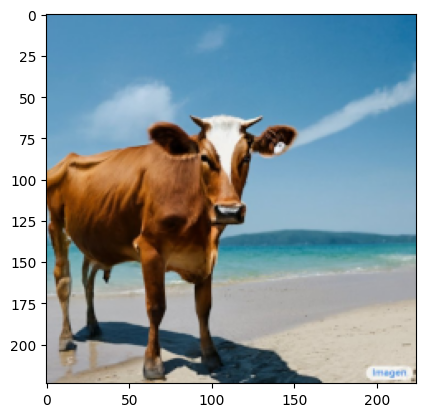

In [7]:
target_size = (224, 224)
image_url = 'https://storage.googleapis.com/keras-cv/models/paligemma/cow_beach_1.png'
cow_image = read_image(image_url, target_size)
matplotlib.pyplot.imshow(cow_image)

Here's a generation call with a single image and prompt. The prompts have to end with a `\n`.

We've supplied you with several example prompts — play around with it! Comment and uncomment the prompt variables to change what prompt you supply the model with.

In [8]:
prompt = 'answer en where is the cow standing?\n'
# prompt = 'svar no hvor står kuen?'
# prompt = 'answer fr quelle couleur est le ciel?'
# prompt = 'responda pt qual a cor do animal?'
output = paligemma.generate(
    inputs={
        "images": cow_image,
        "prompts": prompt,
    }
)
print(output)

answer en where is the cow standing?
beach


Here's a generation call with batched inputs.

In [9]:
prompts = [
    'answer en where is the cow standing?\n',
    'answer en what color is the cow?\n',
    'describe en\n',
    'detect cow\n',
    'segment cow\n',
]
images = [cow_image, cow_image, cow_image, cow_image, cow_image]
outputs = paligemma.generate(
    inputs={
        "images": images,
        "prompts": prompts,
    }
)
for output in outputs:
    print(output)

answer en where is the cow standing?
beach
answer en what color is the cow?
brown
describe en
A brown cow stands on the wet sand at the beach, its head resting on its legs. The sky is clear and blue with a few white clouds. The water is calm and blue, reflecting the sky. The cow's horns are sharp and its eyes are bright. The sand is wet and the waves crash gently against the shore. The cow's shadow stretches long across the sand. The watermark on the image reads "Imagen."
detect cow
<loc0274><loc0000><loc1022><loc0688> cow
segment cow
<loc0278><loc0000><loc1012><loc0686><seg028><seg093><seg116><seg113><seg007><seg065><seg057><seg035><seg081><seg126><seg019><seg093><seg016><seg102><seg003><seg068>


We've supplied you with several example prompts — play around with it! Comment and uncomment the `prompt` variables to change what prompt you supply the model with.

### Other styles of prompts

You may have noticed in the previous step that the provided examples are in several different languages. PaliGemma supports language recognition for 34 different languages. You can find the list of supported languages on [GitHub](https://github.com/google/crossmodal-3600/blob/main/web-data/README.md).

PaliGemma can handle several other prompt styles:

*   **`"cap {lang}\n"`:** Very raw short caption (from WebLI-alt)
*   **`"caption {lang}\n"`:** Nice, COCO-like short captions
*   **`"describe {lang}\n"`:** Somewhat longer, more descriptive captions
*   **`"ocr"`:** Optical character recognition
*   **`"answer en {question}\n"`:** Question answering about the image contents
*   **`"question {lang} {answer}\n"`:** Question generation for a given answer
*   **`"detect {object} ; {object}\n"`:** Count objects in a scene and return the bounding boxes for the objects
*   **`"segment {object}\n"`:** Do image segmentation of the object in the scene

Try them out!

### Parse detect output

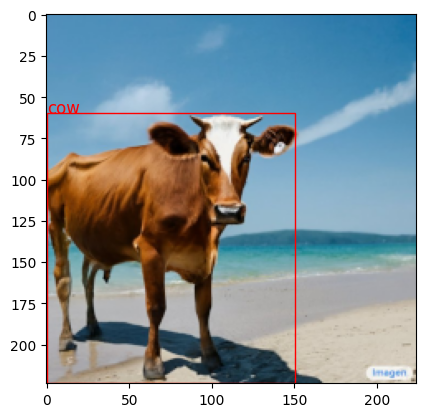

In [10]:
prompt = 'detect cow\n'
output = paligemma.generate(
    inputs={
        "images": cow_image,
        "prompts": prompt,
    }
)
boxes, labels = parse_bbox_and_labels(output)
display_boxes(cow_image, boxes, labels, target_size)

### Parse segment output

In [11]:
# @title  Fetch big_vision code and install dependencies.</font></center>
import os
import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")


# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.7 MB/s eta 0:00:00


Let's take a look at another example image.

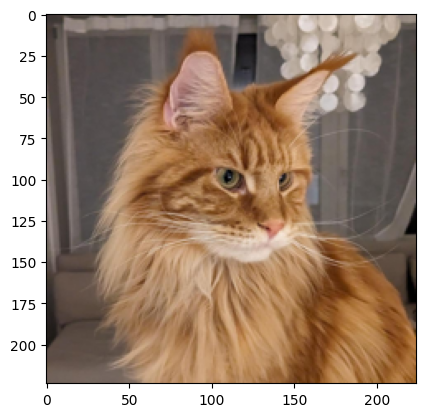

In [12]:
cat = read_image('https://big-vision-paligemma.hf.space/file=examples/barsik.jpg', target_size)
matplotlib.pyplot.imshow(cat)

Here is a function to help parse the segment output from PaliGemma

In [13]:
import  big_vision.evaluators.proj.paligemma.transfers.segmentation as segeval
reconstruct_masks = segeval.get_reconstruct_masks('oi')
def parse_segments(detokenized_output: str) -> tuple[np.ndarray, np.ndarray]:
  matches = re.finditer(
      '<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>'
      + ''.join(f'<seg(?P<s{i}>\d\d\d)>' for i in range(16)),
      detokenized_output,
  )
  boxes, segs = [], []
  fmt_box = lambda x: float(x) / 1024.0
  for m in matches:
    d = m.groupdict()
    boxes.append([fmt_box(d['y0']), fmt_box(d['x0']), fmt_box(d['y1']), fmt_box(d['x1'])])
    segs.append([int(d[f's{i}']) for i in range(16)])
  return np.array(boxes), np.array(reconstruct_masks(np.array(segs)))

Query PaliGemma to segment the cat in the image

In [14]:
prompt = 'segment cat\n'
output = paligemma.generate(
    inputs={
        "images": cat,
        "prompts": prompt,
    }
)

Visualize the generated mask from PaliGemma

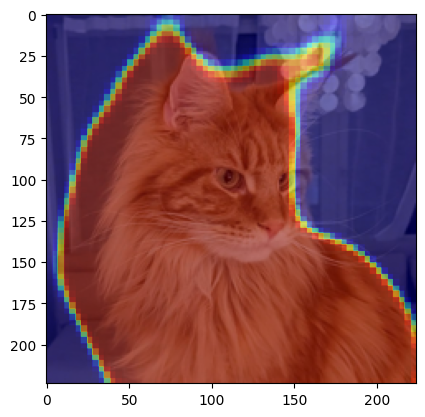

In [15]:
_, seg_output = parse_segments(output)
display_segment_output(cat, seg_output[0], target_size)